In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
def load_hdf5(path):
    """
    Load the HDF5 file and return the data.

    Parameters
    ----------
    path : str
        Path to the HDF5 file.

    Returns
    -------
    tuple
        A tuple containing the data arrays x and y.
    """
    with h5py.File(path, 'r') as f:
        x = f['x'][:]
        y = f['y'][:]
    return x, y

In [3]:
from pathlib import Path
from insilico_mpra.data.utils import split_h5_dataset

d = Path("/grid/koo/home/shared/clg_procap/data/mpra/250813")
for i, f in enumerate(sorted(d.glob("*.h5"))):
    if f.name.endswith("_split.h5"):
        continue
    print(f"[split] {f.name}")
    seed = 20250814 + i
    split_h5_dataset(f, ratios=(0.8, 0.1, 0.1), seed=seed)

/grid/koo/home/nagai/projects/continual_learning/insilico_mpra/.venv/lib/python3.10/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


[split] chr10_119873754_119873954.h5
[split] chr10_73998684_73998884.h5
[split] chr10_78030523_78030723.h5
[split] chr11_47849233_47849433.h5
[split] chr14_23095969_23096169.h5
[split] chr14_68979672_68979872.h5
[split] chr15_68818439_68818639.h5
[split] chr17_28712221_28712421.h5
[split] chr17_39688857_39689057.h5
[split] chr17_41680065_41680265.h5
[split] chr17_44187651_44187851.h5
[split] chr17_753109_753309.h5
[split] chr17_76265987_76266187.h5
[split] chr17_81892520_81892720.h5
[split] chr19_49868479_49868679.h5
[split] chr19_50725809_50726009.h5
[split] chr19_54160695_54160895.h5
[split] chr19_58559816_58560016.h5
[split] chr22_31400493_31400693.h5
[split] chr3_57557086_57557286.h5
[split] chr6_127268203_127268403.h5
[split] chr6_158870631_158870831.h5
[split] chr6_163415399_163415599.h5
[split] chr7_112451137_112451337.h5
[split] chr7_148699610_148699810.h5
[split] chr8_123397621_123397821.h5
[split] chr8_38788019_38788219.h5
[split] chr8_56212728_56212928.h5
[split] chr9_136808

In [4]:
def load_mpra_data(h5file):
    with h5py.File(h5file, 'r') as f:
        x_train = f['x_train'][:].transpose(0, 2, 1)  # (N, 4, L)
        y_train = f['y_train'][:].reshape(-1, 1)  # (N, 1)
        x_valid = f['x_valid'][:].transpose(0, 2, 1)
        y_valid = f['y_valid'][:].reshape(-1, 1)
        x_test = f['x_test'][:].transpose(0, 2, 1)
        y_test = f['y_test'][:].reshape(-1, 1)
        # if x_wt is available
        if 'x_wt' in f and 'y_wt' in f:
            x_wt = f['x_wt'][:].transpose(1, 0)  # (4, L)
            y_wt = f['y_wt'][:] # (1,)
        else:
            x_wt = None
            y_wt = None

    out = {
        'x_train': x_train,  # (N, 4, L)
        'y_train': y_train,  # (N, 1)
        'x_valid': x_valid,  # (N, 4, L)
        'y_valid': y_valid,  # (N, 1)
        'x_test': x_test,  # (N, 4, L)
        'y_test': y_test,  # (N, 1)
    }

    if x_wt is not None:
        out['x_wt'] = x_wt  # (4, L)
        out['y_wt'] = y_wt  # (1,)

    return out

In [5]:
mpra = load_mpra_data("/grid/koo/home/shared/clg_procap/data/mpra/250813/chr10_119873754_119873954_split.h5")

In [6]:
mpra['y_wt'].shape

(1,)

In [7]:
outdir = Path('/grid/koo/home/shared/clg_procap/data/mpra/250813')
tsvpath = outdir / 'mpra_loci_K562_fold1_train.tsv'

split = 'train'

In [8]:
df = pd.read_csv(tsvpath, sep='\t', index_col=0)
df['header'] = df.apply(lambda row: f"{row['chrom']}_{row['start']}_{row['end']}", axis=1)
df.head()

,chrom,start,end,train_index,start_relative,sequence,header
0,chr10,78030523,78030723,9090,640,GCTGCTTCTGGACTCGCCGCTAACACATCTGCGGCATCCTCTCGGC...,chr10_78030523_78030723
1,chr10,73998684,73998884,9620,970,CCCTTATAAGGAGCGCCCGGCGTTAGGGCTCGGGAATCCGGTAGCA...,chr10_73998684_73998884
2,chr17,39688857,39689057,10916,1100,TGCTCTTCGCACTGCAGTACGCAGTCGCGGTACACCGGCTCACGGT...,chr17_39688857_39689057
3,chr17,41680065,41680265,6685,1310,TAGACGGTCATGGAATTGAGAAGTGGGAGCTTGGGCTCGGCTCCTG...,chr17_41680065_41680265
4,chr6,127268203,127268403,5584,900,TCAGCCCTTTCCGCCACCCCCGCCTTGGCTGCTGGGGCAGGCAAGA...,chr6_127268203_127268403


In [9]:
y_items = []
for i in range(30):
    header = df.loc[i, 'header']
    path = outdir / f'{header}.h5'
    x, y = load_hdf5(path)
    print(y[0])
    y_items.append(y)

-0.016325321
-0.44460696
-0.1556371
-0.51676404
-0.8340023
-0.051458202
-0.28376544
-0.74585533
0.23495288
0.70516825
-0.49852276
-0.0401079
-0.31928334
0.20912206
-0.43212342
-1.2097692
0.6870387
-0.3358876
0.33407435
-0.11337054
-0.37855285
-0.77491224
0.06416247
-0.33007497
-0.7273862
0.22563258
-0.64401215
-0.59343994
-0.008239784
0.6969886


In [10]:
def plot_violins_with_wt(
    arrays,
    labels=None,
    inner="quartiles",
    figsize=(8, 4),
    title=None,
):
    n = len(arrays)
    labels = labels or [f"v{i+1}" for i in range(n)]
    line_kwargs = {"color": "red", "linewidth": 2}

    # long-form dataframe
    frames = []
    for lab, a in zip(labels, arrays):
        a = np.asarray(a, dtype=float)
        a = a[~np.isnan(a)]
        frames.append(pd.DataFrame({"group": lab, "value": a}))
    df = pd.concat(frames, ignore_index=True)

    fig, ax = plt.subplots(figsize=figsize)
    sns.violinplot(data=df, x="group", y="value", order=labels, cut=0, inner=inner, ax=ax)

    # WT markers
    for i, a in enumerate(arrays):
        wt = float(np.asarray(a, dtype=float)[0])
        ax.hlines(wt, i - 0.35, i + 0.35, **line_kwargs)  # spans that violin only

    if title is not None:
        ax.set_title(title)

    ax.set_xlabel("")
    ax.set_ylabel("Predicted Activity")
    ax.tick_params(axis="x", rotation=45)
    ax.grid(True, linestyle='--', alpha=0.7)
    fig.tight_layout()
    return fig, ax

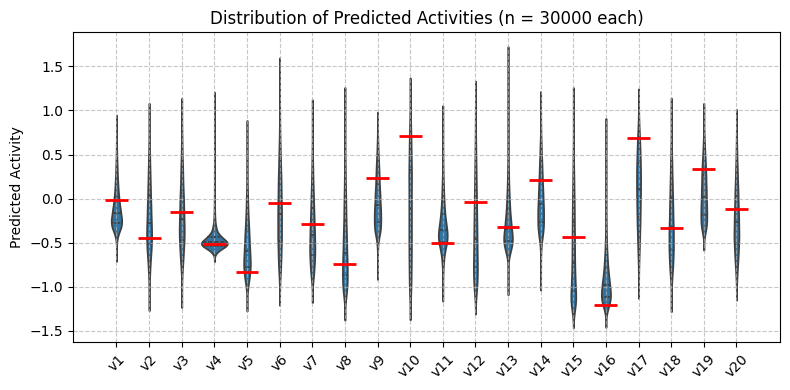

In [ ]:
title = f"Distribution of Predicted Activities (n = {len(y_sorted[0])} each)"
# xlabels = [f'{i}' for i in sorted_indices]

fig, ax = plot_violins_with_wt(y_items[:20], title=title)
plt.savefig(outdir / f'predicted_activity_violins.png', dpi=600)
plt.show()

In [12]:
# sort y_items by the first element
sorted_indices = np.argsort([y[0] for y in y_items])
y_sorted = [y_items[i] for i in sorted_indices]

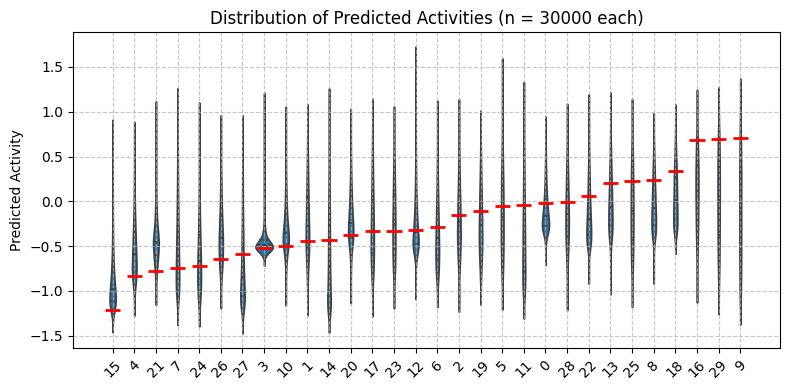

In [13]:
title = f"Distribution of Predicted Activities (n = {len(y_sorted[0])} each)"
xlabels = [f'{i}' for i in sorted_indices]

fig, ax = plot_violins_with_wt(y_sorted, title=title, labels=xlabels)
plt.savefig(outdir / f'predicted_activity_violins.png', dpi=600)
plt.show()